In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
crypto_currency = 'ETH-USD'

start = dt.datetime(2014, 11, 1)
end = dt.datetime(2023,6,1)
Bdata = yf.download("BTC-USD", start, end)
data = yf.download(crypto_currency, start, end)
dollar = yf.download("DX-Y.NYB", start, end)
data["USD"] = dollar["Close"]
data['USD'] = data['USD'].fillna(method='ffill')
rolling_avg = 10
data["Rolling"] = data['Close'].rolling(rolling_avg).mean()
data = data.iloc[rolling_avg:]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/8f/388gtqhn089_jjw6k6zx21480000gn/T/ipykernel_73880/1899025242.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['USD'] = data['USD'].fillna(method='ffill')


In [2]:
price_scaler = MinMaxScaler(feature_range=(0,1))
volume_scaler = MinMaxScaler(feature_range=(0,1))
low_scaler = MinMaxScaler(feature_range = (0,1))
high_scaler = MinMaxScaler(feature_range = (0,1))
roll_scaler = MinMaxScaler(feature_range=(0,1))
#usd_scaler = MinMaxScaler(feature_range=(0,1))
Bprice_scaler = MinMaxScaler(feature_range=(0,1))

scaled_price = price_scaler.fit_transform(data['Close'].values.reshape(-1,1))
scaled_volume = volume_scaler.fit_transform(data['Volume'].values.reshape(-1,1))
scaled_low = low_scaler.fit_transform(data['Low'].values.reshape(-1,1))
scaled_high = high_scaler.fit_transform(data['High'].values.reshape(-1,1))
scaled_roll = roll_scaler.fit_transform(data['Rolling'].values.reshape(-1,1))
#scaled_usd = usd_scaler.fit_transform(data['USD'].values.reshape(-1,1))
scaled_Bprice = Bprice_scaler.fit_transform(Bdata['Close'].values.reshape(-1,1))

prediction_days = 60
x_train, y_train = [], []

for i in range(prediction_days, len(scaled_price)):
    x_train.append(np.column_stack((scaled_price[i-prediction_days:i, 0], scaled_volume[i-prediction_days:i, 0], scaled_low[i-prediction_days:i, 0],scaled_high[i-prediction_days:i, 0],scaled_roll[i-prediction_days:i, 0],scaled_Bprice[i-prediction_days:i, 0] )))
    y_train.append(scaled_price[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))

Epoch 1/25
56/56 [==============================] - 4s 39ms/step - loss: 0.0109 - val_loss: 0.0013
Epoch 2/25
56/56 [==============================] - 2s 32ms/step - loss: 0.0041 - val_loss: 5.0213e-04
Epoch 3/25
56/56 [==============================] - 2s 32ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 4/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0034 - val_loss: 6.7592e-04
Epoch 5/25
56/56 [==============================] - 2s 32ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 6/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0023 - val_loss: 3.9860e-04
Epoch 7/25
56/56 [==============================] - 2s 32ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 8/25
56/56 [==============================] - 2s 32ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 9/25
56/56 [==============================] - 2s 31ms/step - loss: 0.0027 - val_loss: 3.3153e-04
Epoch 10/25
56/56 [==============================] - 2s 32ms/step - loss: 0.0024 - val_loss: 

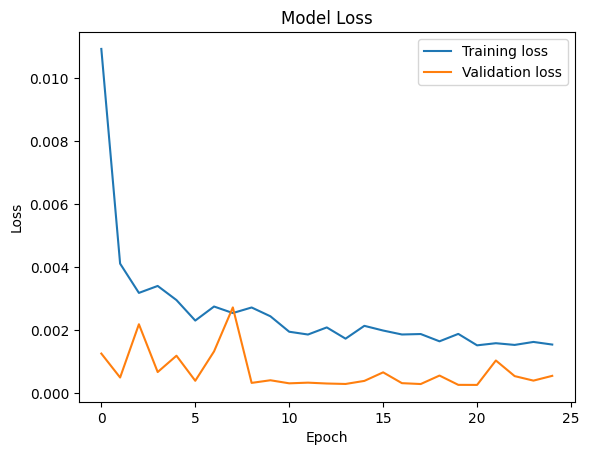

In [3]:
import keras
from keras import layers
model = keras.Sequential()
model.add(layers.LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], 6)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))

model.compile(optimizer= 'adam', loss = 'mean_squared_error')


history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [4]:
test_start = dt.datetime(2023,6,1)
test_end = dt.datetime.now()
Btest_data = yf.download(crypto_currency, test_start, test_end)
test_dollar = yf.download("DX-Y.NYB", test_start, test_end)
Otest_data = yf.download(crypto_currency, test_start - dt.timedelta(days=rolling_avg), test_end)

Otest_data["Rolling"] = Otest_data['Close'].rolling(rolling_avg).mean()

test_data = Otest_data.iloc[rolling_avg:]
test_data["USD"] = test_dollar["Close"]
test_data['USD'] = test_data['USD'].fillna(method='ffill')
actual_prices = test_data['Close'].values
test_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/8f/388gtqhn089_jjw6k6zx21480000gn/T/ipykernel_73880/3956811795.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["USD"] = test_dollar["Close"]
/var/folders/8f/388gtqhn089_jjw6k6zx21480000gn/T/ipykernel_73880/3956811795.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data['USD'] = test_data['USD'].fillna(method='ffill')
/var/folders/8f/388gtqhn089_jjw6k6zx21480000gn/T/ipykernel_73880/3956811795.py:11: SettingWithCopyWarni

,Open,High,Low,Close,Adj Close,Volume,Rolling,USD
Date,,,,,,,,
2023-06-01,1873.914673,1887.705322,1846.227417,1862.201416,1862.201416,5640027197,1856.159314,103.559998
2023-06-02,1862.423706,1910.278442,1851.964722,1907.256592,1907.256592,6097746022,1861.446912,104.019997
2023-06-03,1907.420776,1908.822266,1885.485474,1892.412476,1892.412476,3472274607,1870.678162,104.019997
2023-06-04,1892.398193,1912.205688,1885.651855,1890.513550,1890.513550,3747042696,1879.134143,104.019997
2023-06-05,1890.417603,1890.640503,1780.211548,1811.828369,1811.828369,9246593033,1877.448010,104.000000
...,...,...,...,...,...,...,...,...
2024-04-25,3139.624268,3190.976318,3074.804688,3156.509521,3156.509521,13989030260,3121.774805,105.599998
2024-04-26,3156.384033,3166.188721,3103.104004,3130.164795,3130.164795,10622333862,3126.299268,105.940002
2024-04-27,3129.727051,3279.451172,3071.340088,3252.168213,3252.168213,11820785577,3153.043335,105.940002


11/11 [==============================] - 1s 8ms/step


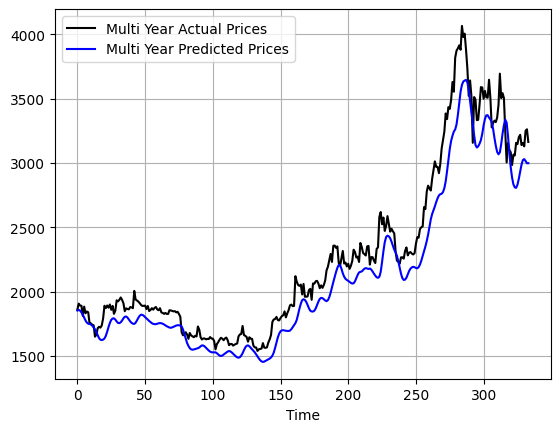

avg distance from actual price [159.35449]
Correct, Wrong and ratio if predicting price is up every day 171 162 0.5135135135135135
overall correct: 164 overall wrong: 169
longest overall correct streak: 6 longest overall wrong streak: 8
explained variance score: 0.9678643427717142
prediction window: 60


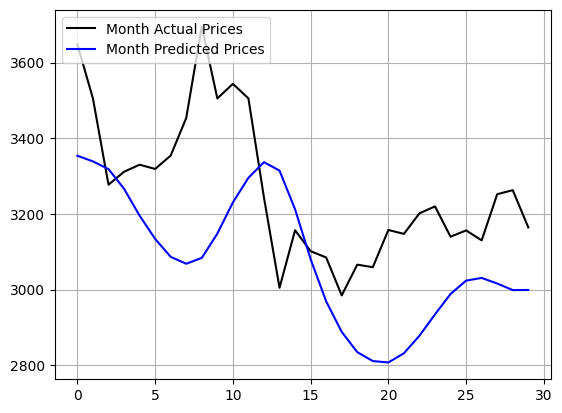

correct: 15 wrong: 14
longest correct streak: 4 longest wrong streak: 3



In [5]:

total_price_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
total_volume_dataset = pd.concat((data['Volume'], test_data['Volume']), axis=0)
total_low_dataset = pd.concat((data['Low'], test_data['Low']), axis=0)
total_high_dataset = pd.concat((data['High'], test_data['High']), axis=0)
total_roll_dataset = pd.concat((data['Rolling'], test_data['Rolling']), axis=0)
#total_usd_dataset = pd.concat((data['USD'], test_data['USD']), axis=0)
total_Bdataset = pd.concat((Bdata['Close'], Btest_data['Close']), axis=0)


model_inputs_price = total_price_dataset[len(total_price_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_volume = total_volume_dataset[len(total_volume_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_low = total_low_dataset[len(total_low_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_high = total_high_dataset[len(total_high_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_roll = total_roll_dataset[len(total_roll_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
#model_inputs_usd = total_usd_dataset[len(total_usd_dataset) - len(test_data) - prediction_days:].values.reshape(-1,1)
model_inputs_Bprice = total_Bdataset[len(total_Bdataset) - len(Btest_data) - prediction_days:].values.reshape(-1,1)


model_inputs_price = price_scaler.transform(model_inputs_price)  
model_inputs_volume = volume_scaler.transform(model_inputs_volume) 
model_inputs_low = low_scaler.transform(model_inputs_low)  
model_inputs_high = high_scaler.transform(model_inputs_high)
model_inputs_roll = roll_scaler.transform(model_inputs_roll)
#model_inputs_usd = roll_scaler.transform(model_inputs_usd)
model_inputs_Bprice = Bprice_scaler.transform(model_inputs_Bprice)

x_test = []


for i in range(prediction_days, len(model_inputs_price)):
    x_test.append(np.column_stack((model_inputs_price[i-prediction_days:i, 0],
                                   model_inputs_volume[i-prediction_days:i, 0],
                                   model_inputs_low[i-prediction_days:i, 0],
                                   model_inputs_high[i-prediction_days:i, 0],
                                  model_inputs_roll[i-prediction_days:i, 0],
                                  model_inputs_Bprice[i-prediction_days:i, 0])))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6)) 


prediction_prices = model.predict(x_test)
prediction_prices = price_scaler.inverse_transform(prediction_prices[:, 0].reshape(-1, 1))


prediction_month = prediction_prices[-30:]
actual_month = actual_prices[-30:]

plt.plot(actual_prices, color = 'black', label = 'Multi Year Actual Prices')
plt.plot(prediction_prices, color = 'blue', label = 'Multi Year Predicted Prices')
plt.xlabel('Time')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
up = 0
down = 0
avg = 0
baseline=0
base = []
for i in range(len(prediction_prices)):
    if i != 0:
        base.append(actual_prices[i - 1])
        avg += abs(prediction_prices[i] - actual_prices[i])
        if actual_prices[i] > actual_prices[i- 1]:
            baseline += abs(actual_prices[i-1]-actual_prices[i])
            up += 1
        else:
            down += 1
        if actual_prices[i - 1] > prediction_prices[i] and actual_prices[i - 1] > actual_prices[i]:
            correct += 1
            a = 1
        elif actual_prices[i - 1] < prediction_prices[i] and actual_prices[i - 1] < actual_prices[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
#print("baseline avg distance from actual price", baseline/len(prediction_prices))           
print("avg distance from actual price", avg/len(prediction_prices))        
print("Correct, Wrong and ratio if predicting price is up every day", up, down, up/(down + up))    
print("overall correct:", correct, "overall wrong:", wrong)
print("longest overall correct streak:", longc_streak, "longest overall wrong streak:", longw_streak)
from sklearn.metrics import explained_variance_score
y_true = actual_prices
y_pred = prediction_prices
print("explained variance score:", explained_variance_score(y_true, y_pred))
print("prediction window:", prediction_days)

plt.plot(actual_month, color = 'black', label = 'Month Actual Prices')
plt.plot(prediction_month, color = 'blue', label = 'Month Predicted Prices')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
for i in range(len(prediction_month)):
    if i != 0:
        if actual_month[i - 1] > prediction_month[i] and actual_month[i - 1] > actual_month[i]:
            correct += 1
            a = 1
        elif actual_month[i - 1] < prediction_month[i] and actual_month[i - 1] < actual_month[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
        
    
print("correct:", correct, "wrong:", wrong)
print("longest correct streak:", longc_streak, "longest wrong streak:", longw_streak)
print()

